In [ ]:
# conda install -c conda-forge implicit # 쥬피터노트북에서 진행할 경우
# !pip install implicit # collba에서 진행할 경우 

In [12]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

유저-아이템 관심도 측정 기준 implicit data: 건강기능식품하트기록 <br>
추후 유저 검색기록, 아이템별접속횟수, 공유 횟수, 커맨트 수 클릭 횟수 등을 추가하여 각 이벤트에 중요도(strength)를 부여하는 방향으로도 발전시키려함. <br>

참고코드) <br>
- https://assaeunji.github.io/ml/2020-11-29-implicitfeedback/
- https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65
- https://jessesw.com/Rec-System/
- https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Articles%20Rec%20System%20Implicit.ipynb <br>

이론참고) <br>
- http://moducon.kr/wp/wp-content/uploads/2020/02/%E1%84%8B%E1%85%B5%E1%84%8B%E1%85%AE%E1%86%BC%E1%84%8B%E1%85%AF%E1%86%AB_%E1%84%8E%E1%85%AE%E1%84%8E%E1%85%A5%E1%86%AB%E1%84%89%E1%85%B5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A6%E1%86%B7-Basics.pdf

## Data Pre-processing

### userID-itemID matrix 생성(using Collab)

In [ ]:
user_df = pd.read_csv("랜덤유저데이터(협업필터링알고리즘에서사용).csv",encoding='utf-8',usecols=['userID','건강기능식품하트기록'])

In [ ]:
columns = ["userID","itemID","eventStrength"]
df_cf_item = pd.DataFrame([],columns=columns)

count = 0
for index,row in user_df.iterrows():
    userID = row['userID']
    items_ID = row['건강기능식품하트기록']
    for itemID in eval(items_ID):
      df_cf_item = df_cf_item.append(pd.Series([userID,itemID,1],index=columns),ignore_index=True)
      count += 1
      if count % 10000 == 0:
        print(count)

In [ ]:
from google.colab import files
df_cf_item.to_csv('user_item_matrix.csv') # collab에서 생성된 csv파일 로컬로 다운로드
files.download('user_item_matrix.csv')

### df matrix 로컬로 불러오기 

In [13]:
user_item_matrix = pd.read_csv('user_item_matrix.csv',index_col='Unnamed: 0')
user_item_matrix.rename(columns={'eventStrength':'Quantity'},inplace=True)
user_item_matrix.head() # 유저별로 특정 itemID를 가진 제품에 좋아요를 눌렀는지 여부
item_lookup = pd.DataFrame(user_item_matrix['itemID'].drop_duplicates())
user_item_matrix = user_item_matrix.groupby(['userID','itemID']).sum().reset_index()
user_item_matrix.head()

,userID,itemID,Quantity
0,0,98,1
1,0,484,1
2,0,528,1
3,0,719,1
4,0,1433,1


### 모델 학습에 쓰일 희소행렬 형태의 matrix (데이터프레임 -> 희소행렬 변환)

ex. 유저가 100만명, 영화가 10만개 있다고 가정. 행렬로 나타내기 위해선 100만*10만 크기의 행렬이 필요함. -> 데이터프레임 형태로 컴퓨터에 저장하려면 storage가 많이 소모됨. -> 희소행렬을 원소값이 0이 아닌 부분에 대해서만 좌표 및 값을 저장하고, 나머지는 모두 0으로 간주하여 저장함으로써 메모리 절약!

In [14]:
# 행을 유저ID, 열을 itemID로 두고, 좋아요수량(Quantity)를 행렬값으로 두는 희소행렬을 만든다
users = list(np.sort(user_item_matrix['userID'].unique()))
items = list(user_item_matrix['itemID'].unique())
quantity = list(user_item_matrix['Quantity'])

rows = user_item_matrix['userID'].astype('category').cat.codes
cols = user_item_matrix['itemID'].astype('category').cat.codes

print(len(users))
print(len(items))

100
14678


In [15]:
purchase_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape = (len(users),len(items)))
purchase_sparse.shape # 100명의 고객 & 14678개의 아이템으로 이루어짐. 유저/아이템간 상호작용은 100*14678.

(100, 14678)

In [16]:
# 상호작용 행렬의 희소성 확인
matrix_size = purchase_sparse.shape[0]* purchase_sparse.shape[1]
num_purchases = len(purchase_sparse.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity # (sparsity < 99.5)
# sparsity: 희소행렬이 얼마나 비었는지 확인할 때 사용
# 협업 필터을 구축하기 위해 필요한 희소성은 약 99.5%. 
# 약 98.6%로 무난하게 구축 가능. 
# sparsity는 유저의 수가 아닌, user-item interaction 데이터 수에 직접적인 영향을 받음.  

98.6415042921379

## Train,Validation 세트 만들기

일반적인 머신러닝 모델의 경우, 얼마나 새로운 데이터에 잘 작동하는지 train데이터로부터 train/test데이터를 따로 나눠 확인할 수 있음. <br>
협업필터링에서는 적절한 행렬분해를 위해, 모든 user-item interaction 데이터를 사용하되, 몇개의 유저-아이템 상호작용을 가려 유저가 그 아이템에 좋아요를 누른 적이 없는 것처럼 만듦. <br>
그렇게 일정한 확률로 일부 상호작용을 숨긴 데이터를 train 데이터로 삼고, test데이터에서 얼마나 유저가 실제로 좋아요를 눌렀던 아이템이 추천되었는지 확인 가능. 


In [17]:
# Train/Validation 세트 만들기
# user-item matrix에서, 훈련 데이터는 percentage 비율(20%)만큼 0으로 바뀔 것임. 

def make_train (matrix, percentage = .2):
    test_set = matrix.copy() # 원본 유저-아이템 행렬의 복사본
    test_set[test_set !=0] = 1 # binary하게 만들기
    
    training_set = matrix.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    
    random.seed(0)
    num_samples = int(np.ceil(percentage * len(nonzero_pairs))) 
    samples = random.sample(nonzero_pairs, num_samples)
    
    user_inds = [index[0] for index in samples] # 훈련 데이터에서 0으로 바뀐 유저의 index
    item_inds = [index[1] for index in samples]
    
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros() # 훈련 데이터에서 percentage 비율만큼 0으로 바뀐 행렬
    
    return training_set, test_set, list(set(user_inds))

# 훈련, 테스트 데이터 생성
product_train, product_test, product_users_altered = make_train(purchase_sparse, 0.2)

## ALS(Alternating Least Squares Recommender) Model Fitting

1. 희소행렬 평점을 신뢰행렬로 만든다. <br>
2. ALS목적) p - 유저 선호도, x - u번째 유저의 벡터, y - i번째 아이템에 대한 벡터 <br>
벡터 x,y를 찾아 p선호도를 구성하는 것이 최종 목표
-> 선호도행렬P를 만들기 위해 유저행렬X와 아이템행렬Y로 분해하자...
3. 원리) 최적의 x,y벡터를 구하기 위해
비용함수를 x에 대해 편미분하여 비용을 최소화하는 x값을 구하고, 
x벡터값 고정시켜 
마찬가지로 비용함수를 y에 대해 편미분하여 최소화하는 값 y벡터를 구함. 
-> x와 y벡터의 곱히 P선호도 행렬에 수렴할 때(MSE가 최소가 될 때까지)까지 앞뒤로 반복
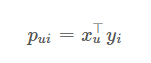

In [8]:
# implicit 라이브러리를 활용하면 Cython & OpenMP를 이용해 앞뒤로 반복하는 과정(Stochastic gradient descent를 이용 최소 MSE를 구하는 과정들)을 병렬적으로 처리할 수 있어 -> 더 빠르게 ALS를 구현할 수 있음

In [18]:
# 모델 생성 

alpha = 15 # ALS모델의 objective function이 MSE error & (모델의 복잡도/과접합 조정)L2항을 사용. 손실함수에 a알파를 곱해서 가중치를 조정

user_vecs, item_vecs = implicit.alternating_least_squares( # user벡터, item벡터 
    (product_train*alpha).astype('double')
    , factors=20
    , regularization = 0.1 
    , iterations = 50)

predictions = [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)] # factorized시킨 user벡터와 item벡터를 내적하면 예측 행렬을 구할 수 있음. 

100%|████████████████████████████████████████████████████████████████████████████████| 50.0/50 [00:01<00:00, 30.03it/s]


### 모델 평가

훈련 데이터 중 20%를 가려놓았었고, 이를 이용해 성능을 평가할 것임. 결과적으로 유저마다 예측 평점이 높은 아이템이 실제로 좋아요를 눌렀던 아이템인지 보아야함. 

In [19]:
from sklearn import metrics

# AUC를 계산하는 함수 
def auc_score (test, predictions):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr,tpr)

In [20]:
# 가려진 정보가 있는 유저마다 AUC 평균을 구하는 함수

def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    input
    1. training_set: 훈련 데이터 (일정 비율로 아이템 구매량이 0으로 가려진 데이터)
    2. prediction: implicit MF에서 나온 유저/아이템 별로 나온 예측 평점 행렬
    3. altered_users: make_train 함수에서 아이템 구매량이 0으로 가려진 유저
    4. test_set: make_train함수에서 만든 테스트 데이터
    ----------------------------------------
    반환
    추천 시스템 유저의 평균 auc
    '''
    # 리스트 초기화
    store_auc = []    

    item_vecs = predictions[1] # 아이템 latent 벡터
    
    for user in altered_users:
        training_row = training_set[user,:].toarray().reshape(-1) # 유저의 훈련데이터
        zero_inds = np.where(training_row == 0) # 가려진 아이템 Index
        
        # 가려진 아이템에 대한 예측
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # 가려진 아이템에 대한 실제값
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        # AUC 계산 
        store_auc.append(auc_score(actual, pred))
    
    return float('%.3f'%np.mean(store_auc))

In [21]:
calc_mean_auc(product_train, product_users_altered, predictions, product_test)
# # ALS 기반 추천시스템은 평균 0.485의 AUC를 갖음. 
# # 예상 원인) 
# # 1) 한 유저가 관심도일 보일 것 같은 아이템 수에 비해, 현재 가지고 있는 items수가 30000개.
# # 2) np,randrange 메소드를 이용해 유저가 좋아요를 누른 제품 리스트를 임의로 만듦. np.randrange는 biased한 output를 내보낸다고 함. 
# # 3) 

0.458

## 아이템 추천하기

In [22]:
# 특정 유저가 좋아요를 누른 아이템 목록을 보여주는 함수
def get_items_interested(userID, mf_train, user_list, item_list, item_lookup):
    '''
    INPUT
    1. customer_id: 고객 ID
    2. mf_train: 훈련 데이터 평점
    3. customers_list: 훈련 데이터에 쓰인 고객 목록
    4. products_list: 훈련 데이터에 쓰인 아이템 목록
    5. item_lookup: 유니크한 아이템 ID와 설명을 담은 테이블
    '''
    user_ind = np.where(user_list == userID)[0][0]
    interested_ind = mf_train[user_ind,:].nonzero()[1]
    prod_codes = item_list[interested_ind]
    
    return item_lookup.loc[item_lookup.itemID.isin(prod_codes)]

In [27]:
# 모델이 예측한 userID 99를 가진 유저가 좋아요를 누른 아이템
user_ID = 99
get_items_interested(user_ID, product_train, np.array(users), np.array(items), item_lookup)

,itemID
138,14256
307,3486
385,29688
480,19965
498,22503
...,...
19541,22156
19675,2150
19747,2515
19849,24953


In [28]:
# 유저의 추천 아이템 반환 함수
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    INPUT
    1. customer_id - Input the customer's id number that you want to get recommendations for
    2. mf_train: 훈련 데이터
    3. user_vecs: 행렬 분해에 쓰인 유저 벡터
    4. item_vecs: 행렬 분해에 쓰인 아이템 벡터
    5. customer_list: 평점 행렬의 행에 해당하는 고객 ID
    6. item_list: 평점 행렬의 열에 해당하는 아이템 ID
    7. item_lookup: 아이템 ID와 설명을 담은 테이블
    8. num_items: 추천할 아이템 개수
    -----------------------------------------------------
    반환    
    구매한 적이 없는 아이템 중 예측 평점이 높은 최고 n개의 추천 아이템
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0]
    pref_vec = mf_train[cust_ind,:].toarray()                   # 훈련 데이터의 실제 좋아요여부
    pref_vec = pref_vec.reshape(-1)                         
    pref_vec[pref_vec > 1] = 0                                  # 좋아요누른 것들을 모두 0으로 
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T)         # 추천 시스템에 기반한 예측 평점
    
    # Min-Max Scaling
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled  # 구매하지 않은 아이템에 대해서만 예측 평점이 남도록
    
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # num_items만큼 내림차순으로 평점 정렬한 index
    
    rec_list = []
    
    for index in product_idx:
        code = item_list[index] # 아이템 id
        # id 담기
        rec_list.append([code]) 
    
    codes = [item[0] for item in rec_list]
    final_frame = pd.DataFrame({'itemID': codes})
    
    return final_frame[['itemID']]

In [30]:
# 모델이 예측한 99번 유저의 좋아요를 누르지 않은 아이템 중 추천할 아이템을 뽑는 함수
rec_items_list = rec_items(user_ID, product_train, user_vecs, item_vecs, np.array(users), np.array(items), item_lookup, num_items = 10)

In [31]:
rec_items_list
df03 = pd.read_csv("03(heart열ID열추가)건강기능식품 품목제조 신고사항 현황_건강기능식품 종류 및 효능.csv",encoding='utf-8',index_col='Unnamed: 0')
df03

rec_items_df = pd.merge(rec_items_list,df03,left_on='itemID',right_on='itemID',how='left')
rec_items_df

,itemID,허가번호,제품명,제조회사,제품타입,제품분류,유통기한,효능,복용법,주의사항,어린이 기호식품,heart
0,5271,2.004002e+10,포스트바이오틱스 키즈핏,(주)비오팜,"이미, 이취가 없고 고유의 향미가 있으며 입자가 있는 미백색 분말",프로바이오틱스,제조일로부터 18개월,[프로바이오틱스] 유산균 증식 및 유해균 억제·배변활동 원활에 도움을 줄 수 있음,"1일 1회, 1회 1포를 물과 함께 또는 우유나 음료에 타서 섭취하십시오.",(가) 질환이 있거나 의약품 복용 시 전문가와 상담할 것\n(나) 알레르기 체질 등...,항목없음,0
1,8081,2.004002e+10,맥포비(Mg4B),(주)알피바이오,"이미, 이취가 없고 고유의 향미가 있는 백색의 제피정제","마그네슘, 비타민 B1, 비타민 B2, 비타민 B6, 비타민 B12",제조일로부터 24개월,[마그네슘] ①에너지 이용에 필요②신경과 근육 기능 유지에 필요\n\n[비타민B1]...,"1일 1회, 1회 1정을 충분한 물과 함께 섭취하십시오.","특이체질이거나 알레르기 체질의 경우, 개인에 따라 과미나반응이 나타날 수 있으므로 ...",항목없음,0
2,23737,2.014002e+10,락토바실루스 루테리 아이디씨씨(IDCC) 3701,일동바이오사이언스(주),고유의 향미가 있고 이미·이취가 없는 노랑 하양색의 입자성이 있는 분말,프로바이오틱스(원료성),제조일로부터 24개월,[프로바이오틱스 제품]①유산균 증식 및 유해균 억제에 도움을 줄 수 있음 ②배변활동...,건강기능식품 원료로 사용,1. 질환이 있거나 의약품 복용 시 전문가와 상담하십시오.\n2. 알레르기 체질 등...,항목없음,3
3,10535,2.004002e+10,올컷 다이어트 락토플러스,주식회사 노바렉스,흰 분홍색 분말,"가르시니아캄보지아 추출물, 프로바이오틱스, 자일로올리고당(기능성원료인정제2009-80호)",제조일로부터 15개월,①유산균 증식 및 유해균 억제에 도움을 줄 수 있음 ②배변활동 원활에 도움을 줄 수...,"1일 2회, 1회 1포를 섭취하십시오.",과량으로 섭취 시 설사를 유발할 수도 있습니다.,항목없음,0
4,24953,2.012002e+10,닥터유산균프리미엄알파,(주)한풍네이처팜,"이미, 이취가 없고 고유의 향미가 있는 연분홍색 분말",프로바이오틱스 제품,제조일로부터 24개월,[프로바이오틱스 제품]①유산균 증식 및 유해균 억제에 도움을 줄 수 있음 ②배변활동...,"1일 1회, 1회 1포를 식후에 섭취하십시오.","- 특이체질, 알레르기 체질이신 경우 성분을 확인하신 후 섭취하여 주시기 바랍니다....",항목없음,1
5,20144,2.015001e+10,슈퍼그린베라 알로에겔분말,주)김정문알로에,"이미, 이취가 없고 고유의 향미가 있는 미백색의 분말",알로에 겔,24개월,①피부건강에 도움을 줄 수 있음 ②장 건강에 도움을 줄 수 있음 ③면역력 증진에 도...,"1일 3회, 1회 1포씩 식전 30분~1시간 전이나 공복 중에 섭취한다.","- 알레르기, 특이체질이신 경우 성분을 확인 하신 후 섭취하여 주시기 바랍니다.\n...",항목없음,0
6,17776,2.004002e+10,서흥 백수오미인플러스,(주)서흥,갈색의 점조성 내용물을 함유한 암갈색의 연질캡슐,"비타민 B6, 비타민A, 감마리놀렌산 함유 유지, 백수오 등 복합추출물(기능성원료인...",제조일부터 24개월,감마리놀렌산 : 혈중 콜레스테롤 개선·혈행개선·면역과민반응에 의한 피부상태 개선·월...,"1일 2회, 1회 2캡슐(1 g)을 충분한 물과 함께 섭취하십시오.",① 영·유아·어린이는 섭취 전 의사와 상담한 후 섭취할 것\n② 임산부와 수유부는 ...,항목없음,3
7,25132,2.004002e+10,시크릿나이트,코스맥스바이오(주),적갈색의 젤리,"가르시니아캄보지아추출물, 난소화성말토덱스트린 제품, N-아세틸글루코사민 제품, 비타민D",제조일로부터 24개월.,[가르시니아캄보지아추출물]①탄수화물이 지방으로 합성되는 것을 억제하여 체지방 감소에...,"1일 1회, 1회 1포(30g)를 씹어서 섭취하십시오.",[난소화성말토덱스트린 제품]반드시 충분한 물과 함께 섭취할 것(액상제외)\r\n[N...,항목없음,1
8,25932,2.009002e+10,익수정,농업회사법인(주)힐링팜,암갈색의 원형정제,홍삼제품,제조일로부터 24개월,[홍삼제품]면역력 증진ㆍ피로회복ㆍ혈소판 응집 억제를 통한 혈액흐름ㆍ기억력 개선ㆍ항산...,"1일 2회, 1회 35정(80mg/1정)","[홍삼제품]의약품(당뇨치료제, 혈액항응고제) 복용 시 섭취에 주의\r\n1) 알레르...",항목없음,0
9,14256,2.006002e+10,혈 청(淸)-Ⅲ 당바이오,콜마비앤에이치(주)음성공장,"이미, 이취가 없고 고유의 향미가 있는 흰색의 코팅정제","홍국, 은행잎 추출물, 바나바잎 추출물, 코엔자임Q10",제조일로부터 24개월,1) 홍국 : 혈중 콜레스테롤 개선에 도움을 줄 수 있음\n2) 은행잎 추출물 : ...,"1일 2회, 1회 1정을 물과 함께 섭취하십시오.","1)특이체질, 알레르기 체질의 경우에는 간혹 개인에 따라 과민반응을 나타낼 수 있으...",항목없음,1
